<a href="https://colab.research.google.com/github/ParisDBRavo/RNN_CNN/blob/main/RNN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de acciones humanas usando RNNs 
En este trabajo se va a comparar las arquitecturas RNN y CNN como se vieron en clase. Para realizar la comparación se utilizará el conjunto [UCF11](https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php). Se realizarán algunos cambios en las arquitecturas para las pruebas. A continuación un ejemplo del conjunto UCF11.
<img src="https://www.crcv.ucf.edu/data/youtube_snaps.jpg" width=800/>

## 1. Preparación


### 1.1Librerias

In [ ]:
# Colab
# https://github.com/TylerYep/torchinfo
!pip install torchinfo
# https://zarr.readthedocs.io/en/stable/
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary
import matplotlib.pyplot as plt
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

## 2. Datos
Para obtener el conjunto de datos usaremos las funciones vistas en la libreta de clases.

Primero se crea una función para obtener los datos de un sitio web.

In [ ]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

Después se unen en un dataset y se dibiden en training y test.

In [ ]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


In [ ]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

In [ ]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

In [ ]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3. Modelos

### 3.1 RNN

Esta arquitectura es muy similar a la vista en clase, sólo se hicieron unas modificaciones como es el caso de que sea bidireccional, al permitir esto, la salida de la capa GRU cambia por lo que también se modifica la entrada de la capa *lineal*. 

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True)
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x
        

In [ ]:
model1 = RNN().eval()
model1(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model1, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              886,272
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.56
Estimated Total Size (MB): 3.71

Comparando con el modelo CNN el número de parámetros es significativamente distinto por lo que se propone cambiar los valores para que sean similares se utiliza entonces se cambia la profundidad a 19. Se entrenaran las 3 redes para comparar.

In [ ]:
class RNN1(nn.Module):

    def __init__(self, input_size=1024, hidden_size=19, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True)
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x
        

In [ ]:
model3 = RNN1().eval()
model3(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model3, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN1                                     [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 38]               119,130
├─Linear: 1-3                            [1, 11]                   429
Total params: 121,607
Trainable params: 121,607
Non-trainable params: 0
Total mult-adds (M): 1.19
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.49
Estimated Total Size (MB): 0.61

### 3.2 CNN
Para crear la arquitectura CNN me baso en la que creamos en clase en la libreta: Red convolucional: MNIST. 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.num_feats = 11*1024
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=10, out_channels=11, kernel_size=3, padding=1),
            nn.ReLU(),
        )       
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 11)
    

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [ ]:
model2 = CNN().eval()
model2(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model2, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 11, 1024]             --
│    └─Conv1d: 2-1                       [1, 11, 1024]             341
│    └─ReLU: 2-2                         [1, 11, 1024]             --
├─Flatten: 1-2                           [1, 11264]                --
├─Linear: 1-3                            [1, 11]                   123,915
Total params: 124,256
Trainable params: 124,256
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.50
Estimated Total Size (MB): 0.63

## 4. Entrenamiento

In [ ]:
def entrenar(modelo):
# optimizador
  opt = optim.Adam(modelo.parameters(), lr=1e-3)
  aux =[]
  aux1 =[]
# ciclo de entrenamiento
  EPOCHS = 100
  for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
      modelo.train()
    
    # entrenamiento de una época
      for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
          y_lgts = modelo(x)
        # calculamos la pérdida
          loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
          opt.zero_grad()
        # retropropagamos
          loss.backward()
        # actulizamos parámetros
          opt.step()

    # desactivamos temporalmente la gráfica de cómputo
      with torch.no_grad():

        # modelo en modo de evaluación
          modelo.eval()
        
          losses, accs = [], []
        # validación de la época
          for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
              y_lgts = modelo(x)
            # calculamos las probabilidades
              y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
              y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
              loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
              acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
              losses.append(loss.item() * 100)
              accs.append(acc.item() * 100)

        # imprimimos métricas
          loss = np.mean(losses)
          acc = np.mean(accs)
          aux.append(loss)
          aux1.append(acc)
          print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
  return aux, aux1

In [ ]:
loss1, acc1 = entrenar(model1)

E 0 loss=300.96 acc=49.69
E 1 loss=302.59 acc=52.19
E 2 loss=304.54 acc=53.12
E 3 loss=318.47 acc=50.00
E 4 loss=310.67 acc=51.88
E 5 loss=317.71 acc=50.62
E 6 loss=313.67 acc=51.25
E 7 loss=316.41 acc=52.50
E 8 loss=318.95 acc=52.50
E 9 loss=313.82 acc=52.50
E10 loss=310.82 acc=50.00
E11 loss=322.47 acc=49.06
E12 loss=342.06 acc=47.50
E13 loss=321.67 acc=48.12
E14 loss=312.38 acc=49.38
E15 loss=322.32 acc=48.75
E16 loss=313.60 acc=50.94
E17 loss=306.96 acc=51.88
E18 loss=308.08 acc=51.56
E19 loss=312.69 acc=53.44
E20 loss=310.90 acc=51.56
E21 loss=313.69 acc=51.25
E22 loss=318.32 acc=50.00
E23 loss=317.93 acc=51.25
E24 loss=313.44 acc=51.88
E25 loss=315.09 acc=50.31
E26 loss=318.24 acc=50.31
E27 loss=317.38 acc=50.94
E28 loss=321.93 acc=50.00
E29 loss=322.03 acc=51.25
E30 loss=323.52 acc=50.62
E31 loss=320.36 acc=50.31
E32 loss=327.17 acc=50.31
E33 loss=321.29 acc=50.31
E34 loss=321.87 acc=50.62
E35 loss=321.19 acc=50.31
E36 loss=323.05 acc=50.94
E37 loss=327.60 acc=48.75
E38 loss=324

In [ ]:
loss2, acc2= entrenar(model2)

E 0 loss=602.94 acc=30.62
E 1 loss=600.69 acc=31.25
E 2 loss=618.50 acc=29.69
E 3 loss=629.15 acc=28.75
E 4 loss=598.71 acc=31.25
E 5 loss=604.01 acc=32.19
E 6 loss=615.73 acc=30.62
E 7 loss=616.38 acc=31.56
E 8 loss=626.42 acc=30.94
E 9 loss=630.89 acc=31.88
E10 loss=603.36 acc=30.62
E11 loss=636.53 acc=29.69
E12 loss=630.17 acc=30.94
E13 loss=637.66 acc=32.19
E14 loss=645.53 acc=30.62
E15 loss=617.11 acc=32.19
E16 loss=631.85 acc=31.25
E17 loss=624.12 acc=31.25
E18 loss=635.03 acc=31.88
E19 loss=630.03 acc=29.38
E20 loss=656.55 acc=29.38
E21 loss=648.43 acc=30.62
E22 loss=623.30 acc=31.88
E23 loss=659.83 acc=29.69
E24 loss=649.14 acc=31.25
E25 loss=638.20 acc=31.56
E26 loss=623.49 acc=31.56
E27 loss=629.72 acc=30.94
E28 loss=657.86 acc=29.38
E29 loss=631.26 acc=32.19
E30 loss=652.83 acc=30.62
E31 loss=645.02 acc=31.88
E32 loss=655.43 acc=30.31
E33 loss=651.52 acc=29.69
E34 loss=653.74 acc=29.06
E35 loss=682.25 acc=28.75
E36 loss=668.50 acc=30.62
E37 loss=659.31 acc=29.69
E38 loss=666

In [ ]:
loss3, acc3 = entrenar(model3)

E 0 loss=355.76 acc=44.06
E 1 loss=340.71 acc=44.06
E 2 loss=345.97 acc=44.06
E 3 loss=350.44 acc=43.75
E 4 loss=351.11 acc=44.06
E 5 loss=340.08 acc=42.81
E 6 loss=343.07 acc=42.81
E 7 loss=355.38 acc=41.56
E 8 loss=350.40 acc=40.31
E 9 loss=359.74 acc=42.19
E10 loss=357.24 acc=40.62
E11 loss=354.49 acc=42.50
E12 loss=359.69 acc=41.56
E13 loss=348.34 acc=43.44
E14 loss=338.45 acc=41.56
E15 loss=333.06 acc=44.06
E16 loss=337.96 acc=43.44
E17 loss=338.47 acc=43.75
E18 loss=341.22 acc=44.38
E19 loss=342.90 acc=43.75
E20 loss=344.05 acc=43.44
E21 loss=342.73 acc=45.94
E22 loss=346.62 acc=43.75
E23 loss=346.34 acc=45.62
E24 loss=346.36 acc=42.50
E25 loss=347.32 acc=44.38
E26 loss=347.28 acc=43.75
E27 loss=350.03 acc=42.81
E28 loss=346.44 acc=43.75
E29 loss=350.79 acc=44.38
E30 loss=353.09 acc=44.06
E31 loss=347.96 acc=45.31
E32 loss=351.14 acc=44.69
E33 loss=352.67 acc=44.06
E34 loss=352.19 acc=43.12
E35 loss=352.09 acc=44.38
E36 loss=353.56 acc=45.62
E37 loss=351.35 acc=45.94
E38 loss=351

## Comentarios y Análisis


100


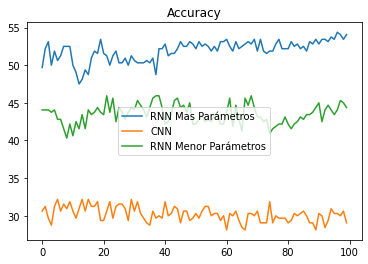

In [ ]:
print(len(acc1))
plt.title('Accuracy')
plt.plot(acc1, label = "RNN Mas Parámetros")
plt.plot(acc2, label = "CNN")
plt.plot(acc3, label = "RNN Menor Parámetros")
plt.legend()
plt.show()

100


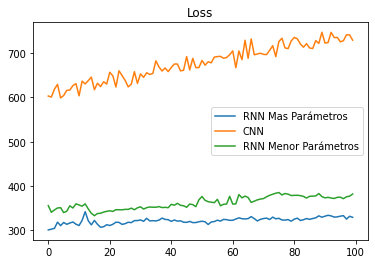

In [ ]:
print(len(loss1))
plt.title('Loss')
plt.plot(loss1, label = "RNN Mas Parámetros")
plt.plot(loss2, label = "CNN")
plt.plot(loss3, label = "RNN Menor Parámetros")
plt.legend()
plt.show()

Aquí se puede observar como RNN es bastante superior a CNN, aunque esto se puede deber a los hiperparámetros como lo son la tasa de aprendizaje. Sin embargo, con los valores utilizados se ve como aunque la exactitud parece mantenerse para el caso de CNN la pérdida va aumentando en cada época. También el disminuir las capas ocultas y por consecuencia disminuir los parámetros de RNN afecta demasiado a la red en lo que a la exactitud corresponde.